<a href="https://colab.research.google.com/github/cledgeja/coding_dojo/blob/main/Machine_Learning/Projects/Project_5_Outlet_Sales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='diagram')



In [2]:
url = 'https://github.com/cledgeja/coding_dojo/blob/612c3b5098afcddd95c76a723ff8a6f5a5e92f5b/Python%20Intro/01%20Week%201%20Python/sales_predictions.csv?raw=true'
df_sales = pd.read_csv(url)
df_ml = df_sales.drop(columns=['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year']).copy()

###1) How many rows and columns?

In [3]:
print(f'{df_sales.shape[0]} rows with {df_sales.shape[1]} columns')

8523 rows with 12 columns


###2) What are the datatypes of each variable?

In [4]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### 3) Are there duplicates? If so, drop any duplicates.

In [5]:
df_sales.duplicated().value_counts() #sum() 
#there are no duplicated rows in this dataset
#df_sales.drop_duplicates()

False    8523
dtype: int64

###4) Identify missing values.



In [6]:
df_sales.isna().sum()[df_sales.isna().sum()>0]

Item_Weight    1463
Outlet_Size    2410
dtype: int64

# Addressing Missing Values


*   5) Decide on how to address the missing values and do it! (This requires your judgement, so explain your choice)

*   6) Confirm that there are no missing values after addressing them. 






### Item_Weight 
Item_Weight is missing 1463 values. Investigate if weights are unique to the Item_Identifier

In [7]:
df_item_unique_weights = df_sales.loc[(df_sales['Item_Weight'].isnull() == False)  ,:].groupby(['Item_Identifier'])['Item_Weight'].nunique().reset_index(name='unique') 
display( f"number of Unique Item_Identifiers is {df_sales['Item_Identifier'].nunique()}")
display(f"number of Unique Item_Identifiers with unique weight {df_item_unique_weights.loc[df_item_unique_weights['unique'] == 1,'unique'].count()}")
print(f"making sure that no unique items have more than 1 weight {df_item_unique_weights.loc[df_item_unique_weights['unique'] > 1,:].count()}")

'number of Unique Item_Identifiers is 1559'

'number of Unique Item_Identifiers with unique weight 1555'

making sure that no unique items have more than 1 weight Item_Identifier    0
unique             0
dtype: int64


1555 Item_Identifiers with 1555 unique weights. There are no Item_Identifiers with different weights. Will try to apply the weights to the Item_Identifiers that are missing the weight

In [8]:
#create dataframe of unique Item_Identifiers and Item_Weights for replacing null weights in df_sales
df_item_weight = df_sales.loc[(df_sales['Item_Weight'].isnull() == False),:].groupby(['Item_Identifier'])['Item_Weight'].mean().reset_index()
df_item_weight.head(5)

,Item_Identifier,Item_Weight
0,DRA12,11.600
1,DRA24,19.350
2,DRA59,8.270
3,DRB01,7.390
4,DRB13,6.115


In [9]:
#iterate through the df_sales dataframe and replace null values with the corresponding weight from df_item_weight
count = 0
for x in range(len(df_sales)):
  if pd.isnull(df_sales.loc[x,"Item_Weight"]) == True :
    item = df_sales.loc[x,'Item_Identifier']
    weight = df_sales.loc[x,'Item_Weight']
    new_weight = df_item_weight.loc[df_item_weight['Item_Identifier'] == item, 'Item_Weight'].min()
      #really just want to return the Items weight here. Since only 1 value, can use any .min() .max() .sum() ... look into better method
    df_sales.loc[(df_sales['Item_Identifier'] == item) & pd.isnull(df_sales['Item_Weight']),'Item_Weight'] = new_weight      
    count+=1
remaining = df_sales['Item_Weight'].isnull().sum()
print(f'{count} Item_Weight values were updated!! {remaining} are still missing')

1142 Item_Weight values were updated!! 4 are still missing


In [10]:
df_sales.loc[pd.isnull(df_sales['Item_Weight']) == True,:] 
#Reviewing the 4 Items with missing weights below, Item_MRP is reported.  
#Will find what the avg price per pound is per Item_Type and apply to the remaining values

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [11]:
#creating new column for price per weight
df_sales['Price_Per_Pound'] =  df_sales['Item_MRP']/df_sales['Item_Weight']
#create dataframe for  average Price_Per_Pound grouped by Item_Type
df_Price_Per_Pound = df_sales.groupby('Item_Type')['Price_Per_Pound'].mean().reset_index()
# apply MRP/Price_Per_Pound = weight


In [12]:

df_Price_Per_Pound.head()

,Item_Type,Price_Per_Pound
0,Baking Goods,11.835553
1,Breads,15.215738
2,Breakfast,12.686476
3,Canned,13.420518
4,Dairy,12.527821


In [13]:
count = 0
for x in range(len(df_sales)):
  if pd.isnull(df_sales.loc[x,"Item_Weight"]) == True :
    item = df_sales.loc[x,'Item_Identifier']
    item_type = df_sales.loc[x,'Item_Type']
      #get the price per pound that realtes to the item type for this specific item
    price_per_pound = df_Price_Per_Pound.loc[df_Price_Per_Pound['Item_Type'] == item_type, 'Price_Per_Pound'].min() 
      #really just want to return the Item_Types Price_Per_Pound here. Since only 1 value, can use any .min() .max() .sum() ... look into better method
      # fill in the blank price_per_pound for the items with missing weights
    df_sales.loc[(df_sales['Item_Identifier'] == item) & pd.isnull(df_sales['Item_Weight']),'Price_Per_Pound'] = price_per_pound
      # MRP / price per pound, should = approximate weight
    df_sales.loc[x,'Item_Weight'] =  df_sales.loc[x,'Item_MRP']/df_sales.loc[x,'Price_Per_Pound']
    count+=1
remaining = df_sales['Item_Weight'].isnull().sum()
print(f'{count} Item_Weight values were updated!! {remaining} are still missing')

4 Item_Weight values were updated!! 0 are still missing


###Outlet_Size
Outlet_Size is missing 2410 values. Investigte if total sales , # of items , or Outlet_Type can predict Outlet_Size

In [14]:
#fill in the missing outlet_size with "missing" for analysis
df_sales.loc[df_sales['Outlet_Size'].isnull() == True,'Outlet_Size'] = 'missing'
df_sales.loc[df_sales['Outlet_Size']=='missing',:].head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Price_Per_Pound
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,missing,Tier 3,Grocery Store,732.3800,9.484115
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,missing,Tier 2,Supermarket Type1,1076.5986,5.985963
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,missing,Tier 2,Supermarket Type1,4710.5350,9.782365
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,missing,Tier 2,Supermarket Type1,838.9080,3.531231
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,missing,Tier 3,Grocery Store,178.4344,7.680776


In [15]:
df_sales.groupby(['Outlet_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type'])['Item_Identifier'].nunique()

Outlet_Type        Outlet_Identifier  Outlet_Size  Outlet_Location_Type
Grocery Store      OUT010             missing      Tier 3                  555
                   OUT019             Small        Tier 1                  528
Supermarket Type1  OUT013             High         Tier 3                  932
                   OUT017             missing      Tier 2                  926
                   OUT035             Small        Tier 2                  930
                   OUT045             missing      Tier 2                  929
                   OUT046             Small        Tier 1                  930
                   OUT049             Medium       Tier 1                  930
Supermarket Type2  OUT018             Medium       Tier 3                  928
Supermarket Type3  OUT027             Medium       Tier 3                  935
Name: Item_Identifier, dtype: int64

In [16]:
df_sales.groupby(['Outlet_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type'])['Item_Outlet_Sales'].sum().round()

Outlet_Type        Outlet_Identifier  Outlet_Size  Outlet_Location_Type
Grocery Store      OUT010             missing      Tier 3                   188340.0
                   OUT019             Small        Tier 1                   179694.0
Supermarket Type1  OUT013             High         Tier 3                  2142664.0
                   OUT017             missing      Tier 2                  2167465.0
                   OUT035             Small        Tier 2                  2268123.0
                   OUT045             missing      Tier 2                  2036725.0
                   OUT046             Small        Tier 1                  2118395.0
                   OUT049             Medium       Tier 1                  2183970.0
Supermarket Type2  OUT018             Medium       Tier 3                  1851823.0
Supermarket Type3  OUT027             Medium       Tier 3                  3453926.0
Name: Item_Outlet_Sales, dtype: float64

###Looking at the matrix above for number of unique items sold, Out010 of Type Grocery Store could be classified as 'Small'.
The other 2 Outlets missing the Size are classified as Supermarket Tye1. Need to investigate if OUT013 Size of High is an error -- seems like values would be small,medium and large. Other than Grocery Stores, which sell similar number of items and both sell half as many items, it is hard to classify the other stores size based on number of items sold or total sales. Will leave the null values for Outlet size as missing for now since the outlets size vs. outlet type may serve the same purpose for analytical needs. 

###6) Confirm that there are no missing values after addressing them.



In [17]:
df_sales.isnull().sum()
#looks good. No missing values

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Price_Per_Pound              0
dtype: int64

#7) Find and fix any inconsistent categories of data (example: fix cat, Cat, and cats so that they are consistent) 

In [18]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Price_Per_Pound            8523 non-null   float64
dtypes: float64(5), int64(1), object(7)
memory usage:

In [19]:
#create function to call grouping by column name
#the unique count of either items or outlets.
def col_group(col_name,unique_by):
  return df_sales.groupby(col_name)[unique_by].nunique()

###Item_Fat_Content

In [20]:
col_group('Item_Fat_Content','Item_Identifier')
#Below shows that 275 unique items have the LF category.

Item_Fat_Content
LF          275
Low Fat    1008
Regular     551
low fat     105
reg         108
Name: Item_Identifier, dtype: int64

In [21]:
#create dictionary to remapp 
remap = {'LF':'Low Fat','reg':'Regular'}
for x in remap.keys():
  df_sales.loc[df_sales['Item_Fat_Content'] == x,'Item_Fat_Content'] = remap[x]
  df_ml.loc[df_ml['Item_Fat_Content'] == x,'Item_Fat_Content'] = remap[x] 
#apply title() to uppercase the first letter of each word in the column 
df_sales['Item_Fat_Content'] = df_sales['Item_Fat_Content'].str.title()
df_ml['Item_Fat_Content'] = df_ml['Item_Fat_Content'].str.title()

In [22]:
col_group('Item_Fat_Content','Item_Identifier')
#showing the unique number of items in each category 
#Looks Good

Item_Fat_Content
Low Fat    1008
Regular     551
Name: Item_Identifier, dtype: int64

###Item_Type

In [23]:
col_group('Item_Type','Item_Identifier')
#Looks Good

Item_Type
Baking Goods             119
Breads                    45
Breakfast                 20
Canned                   120
Dairy                    125
Frozen Foods             155
Fruits and Vegetables    220
Hard Drinks               40
Health and Hygiene        95
Household                170
Meat                      80
Others                    30
Seafood                   10
Snack Foods              220
Soft Drinks               80
Starchy Foods             30
Name: Item_Identifier, dtype: int64

Categories look good!!

###Outlet_Size

In [24]:
col_group('Outlet_Size','Outlet_Identifier')

Outlet_Size
High       1
Medium     3
Small      3
missing    3
Name: Outlet_Identifier, dtype: int64

Leaving these catorgies. value of 'High' might be an error

###Outlet_Location_Type 

In [25]:
col_group('Outlet_Location_Type','Outlet_Identifier')
#Looks good!!

Outlet_Location_Type
Tier 1    3
Tier 2    3
Tier 3    4
Name: Outlet_Identifier, dtype: int64

###Outlet_Type

In [26]:
col_group('Outlet_Type','Outlet_Identifier')
#looks good!!

Outlet_Type
Grocery Store        2
Supermarket Type1    6
Supermarket Type2    1
Supermarket Type3    1
Name: Outlet_Identifier, dtype: int64

###Outlet_Establishment_Year

In [27]:
col_group('Outlet_Establishment_Year','Outlet_Identifier')
#looks good

Outlet_Establishment_Year
1985    2
1987    1
1997    1
1998    1
1999    1
2002    1
2004    1
2007    1
2009    1
Name: Outlet_Identifier, dtype: int64

#8) For any numerical columns, obtain the summary statistics of each (min, max, mean)

In [28]:
df_sales.describe(exclude='object')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Price_Per_Pound
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.873327,0.066132,140.992782,1997.831867,2181.288914,12.720885
std,4.646118,0.051598,62.275067,8.371760,1706.499616,8.025327
min,4.555000,0.000000,31.290000,1985.000000,33.290000,1.686016
25%,8.785000,0.026989,93.826500,1987.000000,834.247400,6.747596
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000,10.966775
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400,16.263237
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,50.775731


# **Part 3**
For Part3, your task is to complete any statistical analyses that might help you understand, explain, or model with your data. This must include at least one of each:

 * Histogram to view the distributions of various features in your dataset.
 * Boxplot to view statistical summaries of various features in your dataset.
 * Heatmap of the correlation between features.

##Histograms

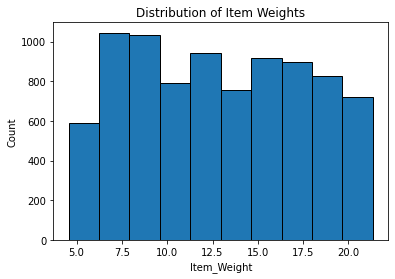

In [29]:
plt.hist(df_sales['Item_Weight'],edgecolor='black');
plt.xlabel('Item_Weight');
plt.ylabel('Count');
plt.title('Distribution of Item Weights');

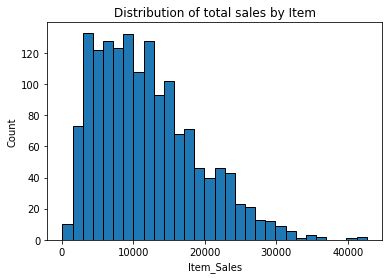

In [30]:
plt.hist(df_sales.groupby(['Item_Identifier'])['Item_Outlet_Sales'].sum(),edgecolor='black',bins=30);
plt.xlabel('Item_Sales');
plt.ylabel('Count');
plt.title('Distribution of total sales by Item');

##Box Plots

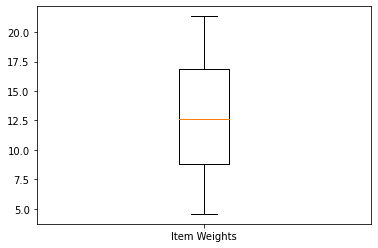

In [31]:
plt.boxplot(df_sales['Item_Weight'],labels=['Item Weights']);

* Appears to be no outliers for Item Weights 

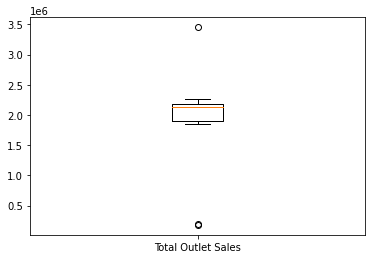

In [32]:
plt.boxplot(df_sales.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].sum(),labels=['Total Outlet Sales']);

* Appears that the sales for one Outlet is skewing the mean to the higher end of the quartile

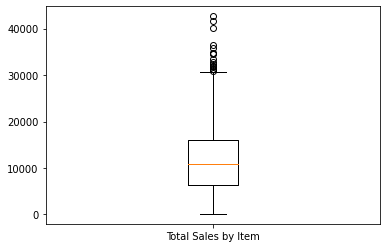

In [33]:
plt.boxplot(df_sales.groupby(['Item_Identifier'])['Item_Outlet_Sales'].sum(),labels=['Total Sales by Item']);

* This boxplot is expected form looking at the histogram above for total outlet sales by item. Outliers do not appear to skew the mean for the entire dataset

##Heat Maps

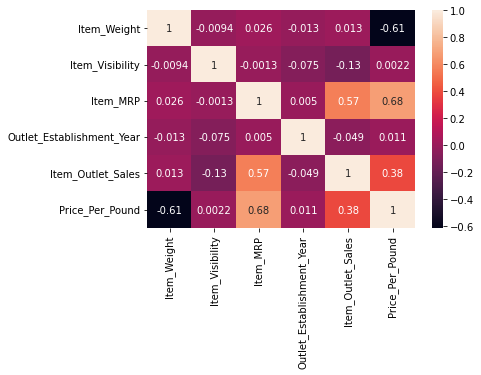

In [34]:
corr = df_sales.corr()
sns.heatmap(corr,annot=True);

* surprised to see that there appeares to be a moderate negative correlation between the items weight and price per pound. Heavier the item the cheaper it is by the pound. Also appears that having a higher MRP (Price) for your Items has a moderate positive correlation to sales.

# Part 5
* Please note: If you imputed missing values based on a calculation on the entire dataset (such as mean), you should now perform that step after the train test split using SimpleImputer.  

In [35]:
#CHECK FOR DUPLICATES
df_ml.duplicated().sum()

0

In [36]:
#Check missing data
display(df_ml.isna().sum()[df_ml.isna().sum()>0])
df_ml[df_ml.isna().any(axis=1)].shape

Item_Weight    1463
Outlet_Size    2410
dtype: int64

(3873, 9)

In [37]:
#review categorical data

dtypes = df_ml.dtypes
str_cols = dtypes[dtypes =='object'].index
for col in str_cols:
  print(f'-col = {col}')
  print(df_ml[col].value_counts(dropna=False))
  print('')
  print('')

-col = Item_Fat_Content
Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


-col = Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


-col = Outlet_Size
Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64


-col = Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


-col = Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype

Identify the features (X) and target (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix. 

In [38]:
y = df_ml['Item_Outlet_Sales']
X = df_ml.drop(columns=['Item_Outlet_Sales'])

Perform a train test split 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create a preprocessing object to prepare the dataset for Machine Learning:



In [40]:
#Column Selectors
num_selector = make_column_selector(dtype_include='number')
nom_selector = ['Item_Type','Item_Fat_Content']
ord_selector = ['Outlet_Size','Outlet_Type','Outlet_Location_Type']
#Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
nom_pipe = make_pipeline(freq_imputer, ohe)
nom_tuple = (nom_pipe, nom_selector)
scaler = StandardScaler()
numeric_pipe = make_pipeline(mean_imputer, scaler)
number_tuple = (numeric_pipe, num_selector)
# Ordinal Encoder
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
Outlet_Type_Labels = ['Grocery Store','Supermarket Type1','Supermarket Type2','Supermarket Type3']
Outlet_Location_Type_Label = ['Tier 1','Tier 2','Tier 3']
Outlet_Size_Label = ['Small','Medium','High']
ordered_labels = [Outlet_Size_Label,Outlet_Type_Labels,Outlet_Location_Type_Label]
ordinal= OrdinalEncoder(categories=ordered_labels,handle_unknown="use_encoded_value",unknown_value=-1)
ordinal_pipe = make_pipeline(most_frequent_imputer,ordinal)
ordinal_tuple = (ordinal_pipe, ord_selector)

In [41]:
preprocessor = make_column_transformer(ordinal_tuple,nom_tuple,number_tuple,
                                       remainder='drop')

In [42]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Grocery '
                                                                              'Store',
                                                                              'Supermarket '
                                                                              'Type1',
                                                                              'Supermarket '
                                                                              'Type2',
                                                                              'Supermarket '
                                                                              'Type3'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '3']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_v...
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Type', 'Item_Fat_Content']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1f4049b1d0>)])

In [43]:
preprocessor.fit(X_train)
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_processed[0]

array([ 1.        ,  2.        ,  2.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.81724868, -0.71277507,  1.82810922])